# Forecasting competition

To help make it easier for you to participate in our motion forecasting challenge, we provide an example notebook for the task

## A simple baseline

Let's say we have our (very very naive) prediction function;

In [2]:
def prediction(trajectory,num_points=30,avg_points=1):
    #a simple prediction function that predict straight line with constant velocity
    velocity_x_mps = []
    velocity_y_mps = []
    for i in range(1,avg_points+1,1):
        velocity_x_mps.append(trajectory[-i,0] - trajectory[-(1+i),0])
        velocity_y_mps.append(trajectory[-i,1] - trajectory[-(1+i),1])
        
    velocity_x_mps = np.mean(velocity_x_mps)
    velocity_y_mps = np.mean(velocity_y_mps)
    
    current_traj = trajectory[-1]
    results = np.zeros((len(trajectory)+num_points,2))
    
    results[0:len(trajectory)] = trajectory
    
    for i in range(num_points):
        results[len(trajectory)+i] = np.array([current_traj[0]+velocity_x_mps,current_traj[1]+velocity_y_mps])
        current_traj = results[len(trajectory)+i]
    return results

Let's try that on our argoverse forecasting test set

In [1]:
from argoverse.data_loading.argoverse_forecasting_loader import ArgoverseForecastingLoader

##set root_dir to the correct path to your dataset folder
# root_dir = '/Users/psangkloy/Downloads/data/test_obs/data/'
root_dir='/mnt/home/husiyuan/code/argo_my/ARGO1/data/test_obs/data'

afl = ArgoverseForecastingLoader(root_dir)

print('Total number of sequences:',len(afl))

Total number of sequences: 78143


In [3]:
%matplotlib inline
import matplotlib.pyplot as plt

import numpy as np

In [4]:
afl = afl[111]
predict_traj = prediction(afl.agent_traj,avg_points=5)

Here is an example of our prediction, initial trajectory in blue and the predicted trajectory in red

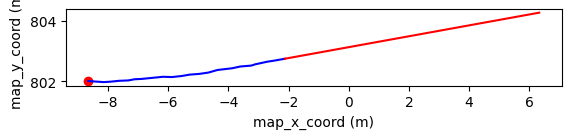

In [6]:
ax = plt.gca()
plt.plot(predict_traj[0,0],predict_traj[0,1],'-o',c='r') #starting point here
plt.plot(predict_traj[:21,0],predict_traj[:21,1],'-',c='b')
plt.plot(predict_traj[20:,0],predict_traj[20:,1],'-',c='r')

plt.xlabel('map_x_coord (m)')
plt.ylabel('map_y_coord (m)')
ax.set_aspect('equal')
plt.show()

Due to the multimodal nature of the problem, our challenge allows for (expects) multiple forecasts for each object.

For the purposes of this tutorial we will use different averaging windows to create multiple entries per object.

In [7]:
def get_multiple_forecasts(afl):
    predict_traj = []
    for i in range(9,3,-1):
        predict_traj.append(prediction(afl.agent_traj,avg_points=(i)))
    return np.array(predict_traj)

In [8]:
predict_traj = get_multiple_forecasts(afl)

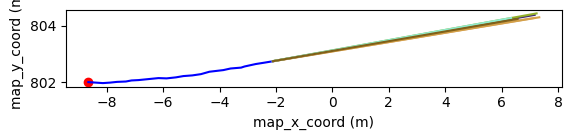

In [9]:
ax = plt.gca()

plt.plot(predict_traj[0,0,0],predict_traj[0,0,1],'-o',c='r') #starting point here
plt.plot(predict_traj[0,:21,0],predict_traj[0,:21,1],'-',c='b')

for i in range(len(predict_traj)):
    plt.plot(predict_traj[i,20:,0],predict_traj[i,20:,1],'-',c=np.random.rand(3,))
plt.xlabel('map_x_coord (m)')
plt.ylabel('map_y_coord (m)')
ax.set_aspect('equal')
plt.show()


## Compute all the results

In [10]:
output_all = {}
counter = 1
for data in afl:
    print('\r'+str(counter)+'/'+str(len(afl)),end="")
    predict_traj = get_multiple_forecasts(data)
    seq_id = int(data.current_seq.name[:-4])
    output_all[seq_id] = predict_traj[:,20:,:]
    counter += 1
    

78143/78143

## Generate the result file

To participate in our competition, you need to upload the result file to our evaluation server on EvalAI https://evalai.cloudcv.org/. Make sure that your results are in the right format, and then call our helper function `generate_forecasting_h5`

In [11]:
from argoverse.evaluation.competition_util import generate_forecasting_h5

output_path = 'competition_files/'

generate_forecasting_h5(output_all, output_path) #this might take awhile

/mnt/home/husiyuan/miniconda3/envs/argo/lib/python3.10/site-packages/pyntcloud/utils/numba.py:5: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def groupby_count(xyz, indices, out):
/mnt/home/husiyuan/miniconda3/envs/argo/lib/python3.10/site-packages/pyntcloud/utils/numba.py:12: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def groupby_sum(xyz, indices, N, out):


78143/78143

You are all set!! 

Simply upload the output file `competition_files/argoverse_forecasting_baseline.h5` to our evaluation server on https://evalai.cloudcv.org/ and see how well you did it